## Superstore Sales Forecasting with Time Series Analysis

### 1. Project Goal
The primary objective of this project is to analyze the historical sales data of a Superstore and develop a reliable forecasting model. By accurately predicting future sales, we aim to provide actionable insights for critical business decisions in areas like inventory management, resource planning, and marketing strategies.

### 2. Process Overview
This notebook follows a structured approach:
*   **Data Loading & Preprocessing:** We will clean and prepare the data for time series analysis.
*   **Exploratory Data Analysis (EDA):** We will visualize the data to identify underlying trends, seasonality, and other patterns.
*   **Time Series Modeling with Prophet:** We will build, train, and evaluate a powerful forecasting model.
*   **Conclusion:** We will summarize the findings and explain the model's tangible business value.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sales-forecasting/train.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
%matplotlib inline

# We use 'encoding='latin1'' to prevent potential errors with special characters
file_path = '/kaggle/input/sales-forecasting/train.csv' 
df = pd.read_csv(file_path, encoding='latin1')

print("Data loaded successfully. Here are the first 5 rows:")
df.head()

Data loaded successfully. Here are the first 5 rows:


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [3]:
# For this forecast, we only need the 'Order Date' and 'Sales' columns
df_ts = df[['Order Date', 'Sales']].copy()

# Convert 'Order Date' to a proper datetime format.
# We specify the format to ensure pandas interprets the dates correctly.
df_ts['Order Date'] = pd.to_datetime(df_ts['Order Date'], format='%d/%m/%Y')

# Set 'Order Date' as the index, which is standard practice for time series data
df_ts = df_ts.set_index('Order Date')

# To get a clearer view of the trend, we will resample the daily data to monthly sales totals
monthly_sales = df_ts['Sales'].resample('MS').sum()

print("Data successfully preprocessed for time series analysis.")
print("First 5 months of aggregated sales data:")
monthly_sales.head()

Data successfully preprocessed for time series analysis.
First 5 months of aggregated sales data:


Order Date
2015-01-01    14205.707
2015-02-01     4519.892
2015-03-01    55205.797
2015-04-01    27906.855
2015-05-01    23644.303
Freq: MS, Name: Sales, dtype: float64

### Exploratory Data Analysis (EDA)

Now that our data is prepared, let's visualize it to understand its structure. We will look for:
*   **Overall Trend:** The long-term direction of sales.
*   **Seasonality:** Repeating patterns or cycles within a year.

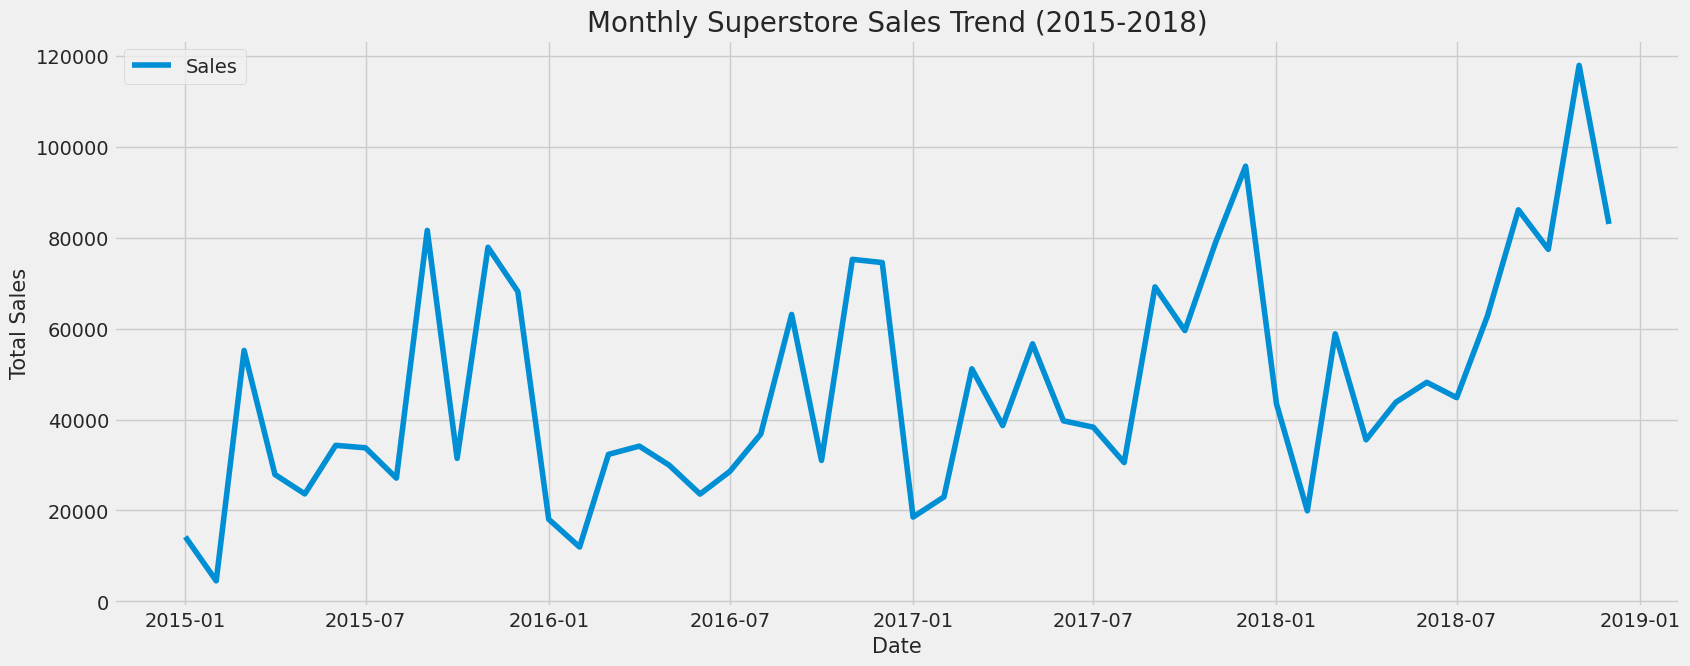

In [4]:
# Plotting the overall monthly sales trend over time to get a high-level overview
plt.figure(figsize=(18, 7))
plt.plot(monthly_sales, label='Sales')
plt.title('Monthly Superstore Sales Trend (2015-2018)', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Total Sales', fontsize=15)
plt.legend()
plt.show()

/tmp/ipykernel_13/915476176.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Automatically adjusts plot parameters for a tight layout.


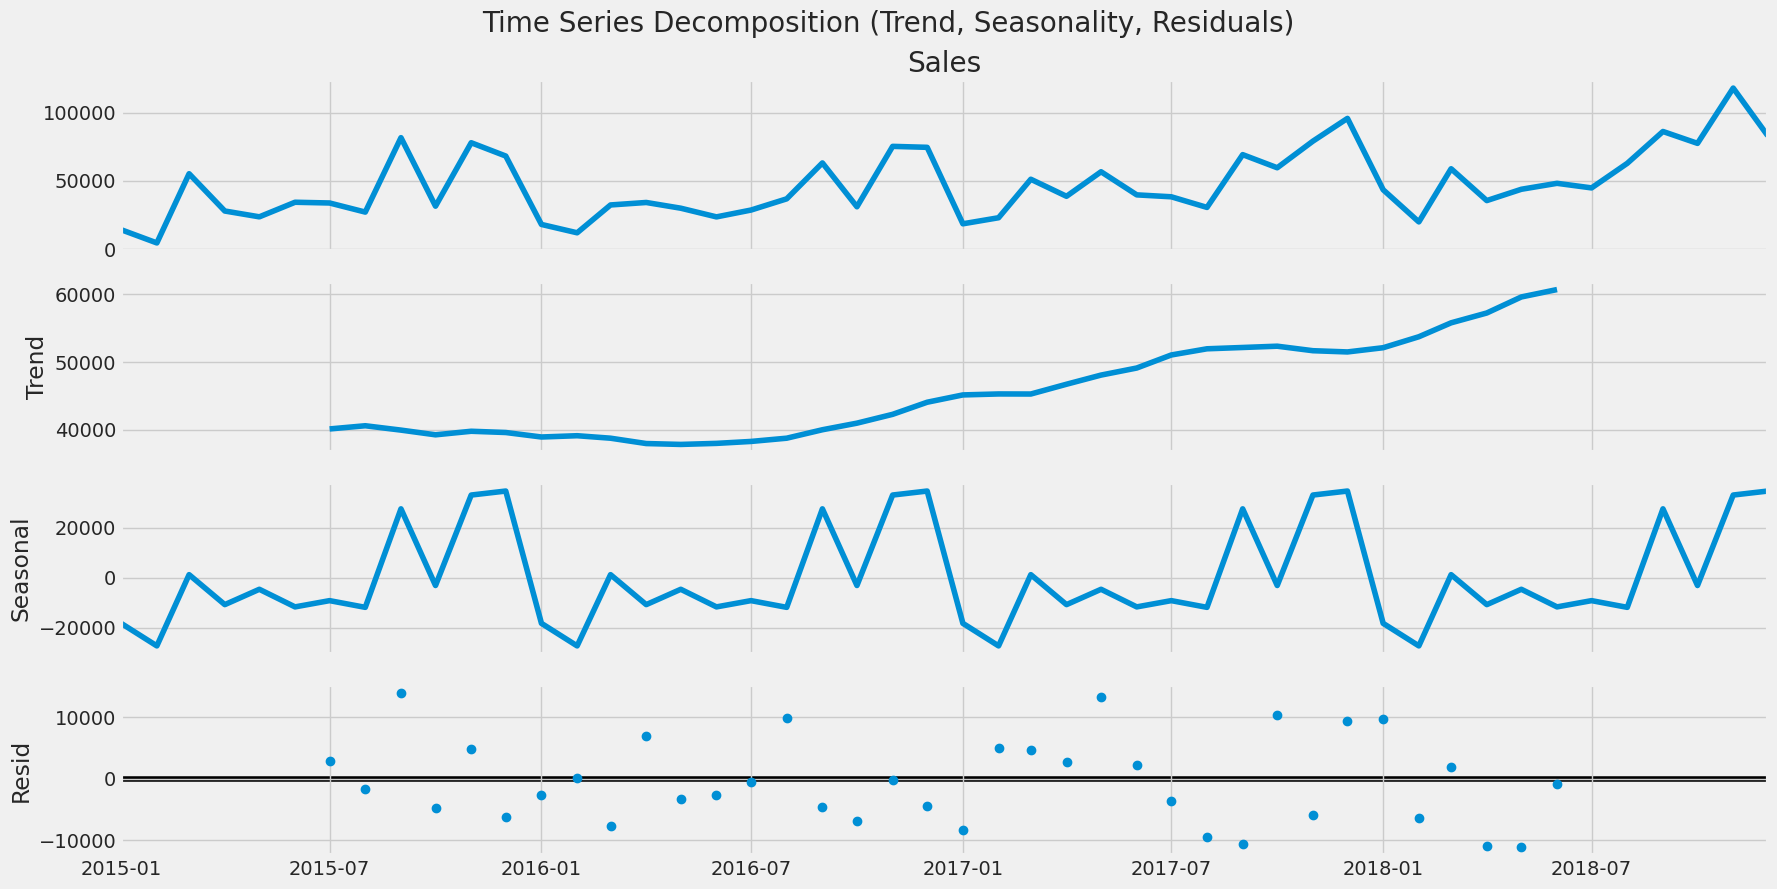

In [5]:
# Decompose the time series to analyze its components
decomposition = seasonal_decompose(monthly_sales, model='additive')

# Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches(18, 10)
plt.suptitle('Time Series Decomposition (Trend, Seasonality, Residuals)', fontsize=20, y=0.92)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Automatically adjusts plot parameters for a tight layout.

plt.show()

### Time Series Modeling with Prophet

Based on our EDA, we observed a clear upward trend and strong yearly seasonality. Facebook's **Prophet** library is an excellent choice for this type of data as it is robust and designed to handle these components automatically.

In [6]:
!pip install prophet -q

from prophet import Prophet

# Prophet requires a specific dataframe format: 
# The timestamp column must be named 'ds' and the value column must be named 'y'
prophet_df = monthly_sales.reset_index()
prophet_df.columns = ['ds', 'y']

# Initialize and train the Prophet model
# We specify yearly_seasonality=True because our EDA confirmed it.
model = Prophet(yearly_seasonality=True)
model.fit(prophet_df)

print("Prophet model trained successfully.")

06:16:08 - cmdstanpy - INFO - Chain [1] start processing
06:16:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet model trained successfully.


In [7]:
# Create a future dataframe for predictions (for the next 12 months)
future = model.make_future_dataframe(periods=12, freq='MS')

# Generate the forecast
forecast = model.predict(future)

print("Forecast for the next 12 months generated. Here are the final predictions:")
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Forecast for the next 12 months generated. Here are the final predictions:


,ds,yhat,yhat_lower,yhat_upper
55,2019-08-01,55817.869145,46746.037504,65469.750127
56,2019-09-01,101744.663677,91931.962708,111066.180862
57,2019-10-01,69092.066549,60151.527801,78657.045054
58,2019-11-01,111918.978462,102954.725298,121027.718783
59,2019-12-01,94436.191385,85524.463415,103767.922555


### Visualizing the Forecast

Now, let's visualize our model's predictions. A plot showing the historical data, the forecast, and the uncertainty intervals is the most powerful output of our project.

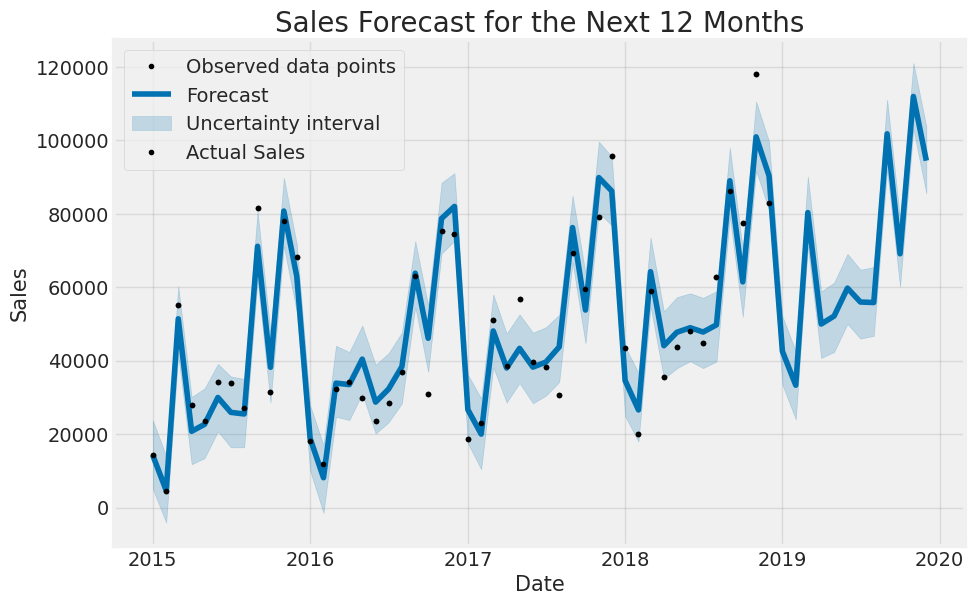

In [8]:
# Plot the forecast results using Prophet's built-in plotting function
fig1 = model.plot(forecast)
plt.title('Sales Forecast for the Next 12 Months', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Sales', fontsize=15)

# Add markers for the actual data points for better clarity and comparison
plt.plot(prophet_df['ds'], prophet_df['y'], '.k', label='Actual Sales')
plt.legend()
plt.show()

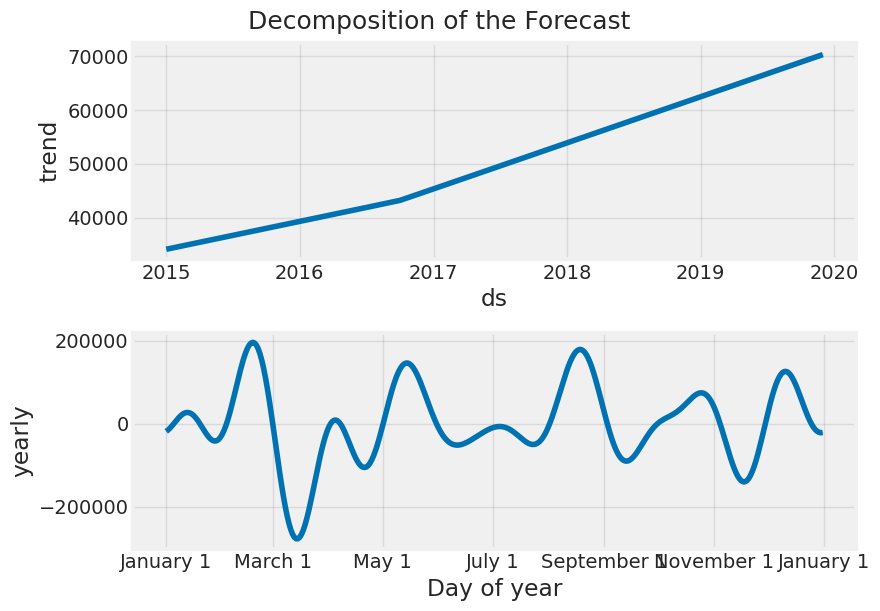

In [9]:
# Set a reliable font to prevent character errors.
plt.rcParams['font.family'] = 'DejaVu Sans'

# Plot the forecast components (trend and seasonality).
fig2 = model.plot_components(forecast)

# Add a main title to the plot.
plt.suptitle('Decomposition of the Forecast', fontsize=18, y=1.02)

plt.show()

# Conclusion & Business Value

This project successfully developed a robust sales forecasting model using Facebook Prophet.

### Key Insights:
- **Upward Trend:** The analysis confirmed a consistent upward trend in sales, signaling healthy business growth.
- **Strong Seasonality:** A strong yearly seasonality was identified, with sales consistently peaking towards the end of the year (November-December), which is likely driven by holiday shopping.

### Business Impact:
This forecasting model is a valuable strategic asset for the Superstore. It enables the business to:
- **Optimize Inventory:** Proactively manage stock levels to meet demand during peak seasons and avoid costly overstocking.
- **Plan Marketing Campaigns:** Align marketing spend with periods of high customer activity to maximize return on investment.
- **Improve Financial Planning:** Forecast future revenue with greater accuracy for more effective budgeting and cash flow management.

This project demonstrates a practical, end-to-end application of time series forecasting to drive tangible business value.